In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sqlite3

## Load Dataset

In [59]:
conn = sqlite3.connect('../../data/interim/raw_data.sqlite')

In [83]:
query = """
    select * from {table}
    """
df_portfolio = pd.read_sql_query(query.format(table='portfolio'), conn)
df_profile = pd.read_sql_query(query.format(table='profile'), conn)
df_transcript = pd.read_sql_query(query.format(table='transcript'), conn)

In [94]:
df_portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
df_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
df_profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
df_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            17000 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [8]:
df_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


## Clean Data

### portfolio

In [95]:
# check duplicates
df_portfolio[df_portfolio.duplicated('id')]

,reward,channels,difficulty,duration,offer_type,id


In [9]:
# find types of channels
df_portfolio['channels'] = df_portfolio['channels'].apply(eval)

channels = []
for c in df_portfolio['channels'].values.flatten():
    channels.extend(c)
channels = list(set(channels))
channels

['mobile', 'email', 'web', 'social']

In [10]:
# create dummies for channels
def convert_list_to_dummy(row, channel):
    return 1 if channel in row['channels'] else 0
    
for channel in channels:
    df_portfolio[channel] = df_portfolio.apply(convert_list_to_dummy, channel=channel, axis=1)

# delete the original column
df_portfolio.drop('channels', axis=1, inplace=True)

In [18]:
df_portfolio.head()

,reward,difficulty,duration,offer_type,id,mobile,email,web,social,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,1,0,0,1,0


In [17]:
# create dummies for offer_type
df_portfolio = pd.concat([df_portfolio, pd.get_dummies(df_portfolio['offer_type'])], axis=1)

# delete the original column
df_portfolio.drop('offer_type', axis=1, inplace=True)

In [86]:
# validate no missing values
assert df_portfolio.isnull().sum().sum() == 0

### profile

In [89]:
# check duplicates
df_profile[df_profile.duplicated('id')]

,gender,age,id,became_member_on,income


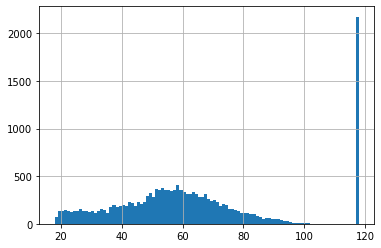

In [68]:
# check age distribution
df_profile['age'].hist(bins=100)
plt.show()

In [69]:
df_profile[df_profile['age'] > 100].groupby('age')['id'].count()

age
101       5
118    2175
Name: id, dtype: int64

There are a fair size of users who are 118 years old. That's way too impressive if it is true! My guess is that these users didn't set their birth day and default setting thought they were 118 years old. We may need more details for this. To be as unbiased as possible, here we replace the age of these people with the median age and create a column to keep their ages' characteristic.

In [72]:
# create dummies for gender
df_profile['gender'] = df_profile['gender'].replace('None', np.nan)
df_profile = pd.concat([df_profile, pd.get_dummies(df_profile['gender'], prefix='gender', dummy_na=True)], axis=1)

# remove the original column
df_profile.drop('gender', axis=1, inplace=True)

In [70]:
# create a new column for "118-year-old" user
df_profile['is_outlier_age'] = np.where(df_profile['age'] == 118, True, False)

# replace age with the median
df_profile['age'] = np.where(df_profile['age'] == 118, df_profile['age'].median(), df_profile['age'])

In [75]:
df_profile.head()

,age,id,income,is_outlier_age,gender_F,gender_M,gender_O,gender_nan,year_member_created,month_member_created
0,58.0,68be06ca386d4c31939f3a4f0e3dd783,NaN,True,0,0,0,1,2017,2
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,False,1,0,0,0,2017,7
2,58.0,38fe809add3b4fcf9315a9694bb96ff5,NaN,True,0,0,0,1,2018,7
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,False,1,0,0,0,2017,5
4,58.0,a03223e636434f42ac4c3df47e8bac43,NaN,True,0,0,0,1,2017,8


In [74]:
# create columns the year and the month member created
df_profile['year_member_created'] = df_profile['became_member_on'].astype(str).str[:4].astype(int)
df_profile['month_member_created'] = df_profile['became_member_on'].astype(str).str[4:6].astype(int)

# remove the original column
df_profile.drop('became_member_on', axis=1, inplace=True)

In [36]:
# check % missing values of income
df_profile['income'].isnull().mean()

0.12794117647058822

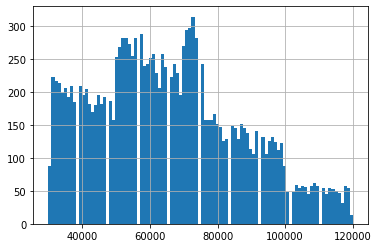

In [45]:
# check income distribution
df_profile['income'].hist(bins=100)
plt.show()

In [37]:
# create column to show the income is missing
df_profile['is_income_missing'] = df_profile['income'].isnull()

In [76]:
# replace the missing income with median
df_profile['income'] = np.where(df_profile['income'].isnull(), df_profile['income'].median(), df_profile['income'])

In [84]:
# validate no missing values
assert df_profile.isnull().sum().sum() == 0

AssertionError: 

### transcript

In [87]:
df_transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [100]:
# check duplicates
df_transcript[df_transcript.duplicated(keep=False)]

,person,event,value,time
66122,3dde94fa581145cb9f206624f1a94d5a,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,168
66123,3dde94fa581145cb9f206624f1a94d5a,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,168
66782,e9fb6ed2cecb4980ba98c86abc9c91e3,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,168
66783,e9fb6ed2cecb4980ba98c86abc9c91e3,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,168
67613,a7dc060f6fc94ca7bf71fbb188187dca,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,168
...,...,...,...,...
304756,0785f1fce0b04ba08e01c7d2ebab4917,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,708
305550,b7e216b6472b46648272c29a52a86702,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714
305551,b7e216b6472b46648272c29a52a86702,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714
306455,f3e801caeafe4899b3b989b586e74ac7,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,714


Looks like there are many duplicate rows. Because these identical transcript shared the same time and value, it is reasonable to say they are duplicates and we only need to keep the unique rows.

In [101]:
# remove duplicates

In [102]:
# create dummies for event

In [ ]:
# unstack value

In [ ]:
# check time distribution